<a href="https://colab.research.google.com/github/quanvu0996/TF_cert_training/blob/main/v2.4_ML20M_item%20feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import psutil
# gives a single float value
print(psutil.cpu_percent())
# gives an object with many fields
print(psutil.virtual_memory())
# you can convert that object to a dictionary print(dict(psutil.virtual_memory()._asdict()))
# you can have the percentage of used RAM
print(psutil.virtual_memory().percent)
# you can calculate percentage of available memory
print(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)

38.8
svmem(total=13617745920, available=12484489216, percent=8.3, used=891908096, free=11769933824, active=1008664576, inactive=639320064, buffers=67059712, cached=888844288, shared=1236992, slab=125091840)
8.3
91.67808893881903


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

In [3]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import gc

import tensorflow_text as text
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split

In [4]:
tf.__version__

'2.8.0'

In [5]:
itemCol = 'movieId'
userCol = 'userId'

In [6]:
# DGX setup
# fpath = "./ml-20m" 

#colab setup
from google.colab import drive
drive.mount('/content/gdrive')
fpath = "/content/gdrive/MyDrive/RECOMMENDER_STUDIES/data/ml-20m"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
# Loading data
ratings = pd.read_csv(fpath+'/ratings.csv')

ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
...,...,...,...,...
20000258,138493,68954,4.5,1258126920
20000259,138493,69526,4.5,1259865108
20000260,138493,69644,3.0,1260209457
20000261,138493,70286,5.0,1258126944


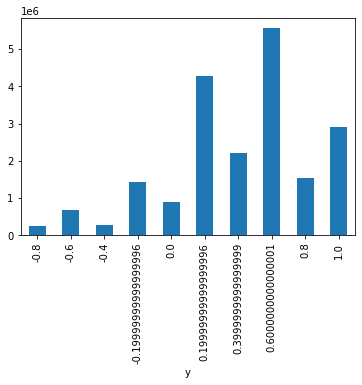

In [8]:
# Normalize rating về dạng -1 -> 1 (-1 = ghét, 1 = thích)
ratings["y"] = ratings["rating"]/2.5-1

# Kiểm tra rating trong khoảng -1 -> 1
ratings.groupby("y")["y"].count().plot(kind='bar')

In [9]:
# Loading movie
# movies = pd.read_csv(fpath+'/movies.csv')
# movies["year"]=movies["title"].apply(lambda x: x[-5:-1])
# movies["genres"] = movies["genres"].apply(lambda x: ' ' if x == '(no genres listed)' else ' '.join(x.split('|')) )
# movies["title"]= movies["title"].apply(lambda x: x[0:-7])

In [10]:
# movies.head()

In [11]:
# ratings = ratings.merge(movies, on='movieId', how = 'left')

# BERT

In [12]:
# tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
# tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [13]:
# bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [14]:
# preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')

In [15]:
# bert_model(preprocessing_layer(movies["title"]))

# Model v2.3
Sử dụng constrastive loss thay cho onehot

In [16]:
# Chia dữ liệu thành các tập cho model clustering, nhãn recommendation và test
#     warm_up_mask: ratings đã quan sát
#     target: rating dùng để đánh giá kết quả recommend của module recommend cho từng người dùng
#     test: đánh giá độc lập
# TODO: chia tập dữ liệu theo user-wise => đánh giá với những user hoàn toàn mới thì model có học được không?
# v2.1. gộp warm_up và mask thành 1
def dataset_split(ratings):
    train, test = train_test_split(ratings, test_size= 0.25)
    warm_up_mask, target = train_test_split(train, test_size= 0.25)
    return warm_up_mask, target, test

warm_up_mask, target, test = dataset_split(ratings)

In [17]:
# Kiểm tra số lượng ratings
warm_up_mask.shape[0], target.shape[0], test.shape[0]

(11250147, 3750050, 5000066)

In [19]:
warm_up_mask.head()

,userId,movieId,rating,timestamp,y
9716240,67199,276,4.0,828654920,0.6
17747682,122702,1200,5.0,955083228,1.0
18467500,127846,913,5.0,851353898,1.0
5505230,37851,5418,4.0,1117543129,0.6
18235676,126111,1083,4.0,921917594,0.6


In [20]:
# df = warm_up_mask.head()
# df["item_ft_str"] = df[item_ft_cols].apply(lambda x: list(x[item_ft_cols]), axis=1)

In [21]:
# v2.2: chỉ groupby, không padding
def get_interaction_set(interaction, max_item = None, top_k_item = None, item_ft_strs = None, item_ft_nums=None):
    """
    Input:
        interaction: df[userCol, itemCol, y]: dữ liệu đầu vào
        max_item: int: item num limit
    Output:
        df, itemCol: list, y: list, itemCol_str: string, userCol as index
        list item sắp xếp theo giảm dần độ lớn rating
    """
    items = ratings.groupby(itemCol).count().sort_values(by=userCol, ascending=False)
    if top_k_item is not None:
        top_items = items.head(top_k_item).index
        interaction = interaction[interaction[itemCol].isin(top_items)]
    else:
        top_items = items.index

    # Xử lý item feature
    if item_ft_strs is not None:
        interaction["item_ft_strs"] = interaction[item_ft_strs].apply(lambda x: ' '.join(x[item_ft_strs]), axis=1)
    
    if item_ft_nums is not None:
        interaction["item_ft_nums"] = interaction[item_ft_nums].apply(lambda x: list(x[item_ft_nums]), axis=1)

    # Sắp xếp item theo thứ tự giảm dần rating (về sau cắt padding sẽ ưu tiên giữ lại item có rating cao)
    rindex = interaction.groupby(userCol)["y"].transform(lambda grp: grp.sort_values(ascending=False).index)
    interaction = interaction.reindex(rindex)
    
    # Chuyển thành warm-up set theo từng user
    if (item_ft_nums is not None) and (item_ft_strs is not None):
        interaction = interaction.groupby("userId").agg({itemCol:list, "y":list, "item_ft_strs":list, "item_ft_nums":list })
    elif item_ft_strs is not None:
        interaction = interaction.groupby("userId").agg({itemCol:list, "y":list, "item_ft_strs":list })
    elif item_ft_nums is not None:
        interaction = interaction.groupby("userId").agg({itemCol:list, "y":list, "item_ft_nums":list })
    else:
        interaction = interaction.groupby("userId").agg({itemCol:list, "y":list })

    # Giới hạn độ dài warm_up size
    if max_item is not None:
        interaction[itemCol] = interaction[itemCol].apply(lambda x: x[0:max_item])
        interaction["y"] = interaction["y"].apply(lambda x: x[0:max_item])
        if item_ft_strs is not None:
            interaction["item_ft_strs"] = interaction["item_ft_strs"].apply(lambda x: x[0:max_item])
        if item_ft_nums is not None:
            interaction["item_ft_nums"] = interaction["item_ft_nums"].apply(lambda x: x[0:max_item])

    return interaction, top_items

top_k_item = 5000
wu_size = 200
mask_size = 50
max_item = wu_size + mask_size
item_ft_strs = ["title", "genres"]
item_ft_nums = ["year"]

interac_df, top_items = get_interaction_set(warm_up_mask[warm_up_mask[userCol]<100]
                    , max_item = max_item
                    , top_k_item = top_k_item
                    , item_ft_strs = item_ft_strs
                    , item_ft_nums = item_ft_nums )
interac_df

KeyError: ignored

### Class  model

In [13]:
# Khởi tạo cấu hình: xác định encoder, decoder, mapping dims
class Efficient_Rec(tf.keras.Model):
  def __init__(self, encoder, decoder, reps, use_tf_function=False):
    super().__init__()
    self.use_tf_function = use_tf_function

    self.encoder = encoder
    self.decoder = decoder
    self.reps = reps

  def train_step(self, inputs):
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [14]:
def _wu_mask_split(self, batch_inputs, mask_ratio = 0.25):
    "Chia ratings và items thành mask, warm up"
    input_items, input_ratings = batch_inputs[itemCol], batch_inputs["y"]

    def list_split(input, mask_ratio = 0.25, seed= 42):
        return train_test_split(input[0:(wu_size+mask_size)], test_size= mask_ratio, random_state=seed)

    seed = random.randint(1, 100)
    items = input_items.apply(lambda x: list_split(x, mask_ratio, seed))
    ratings = input_ratings.apply(lambda x: list_split(x, mask_ratio, seed))

    wu_item_list = items.apply(lambda x: x[0])
    mask_item_list = items.apply(lambda x: x[1])

    wu_rating_list = ratings.apply(lambda x: x[0])
    mask_rating_list = ratings.apply(lambda x: x[1])
    return (wu_item_list, wu_rating_list), (mask_item_list, mask_rating_list)

Efficient_Rec._wu_mask_split = _wu_mask_split

In [15]:
def _preprocess(self, inputs, padding_size = 100):
    """
    Padding về wu_size và mask_size, convert list of items => string of items
    batch_inputs: df: itemStr, y"""

    def padding_list(list_item, wu_size, value=0, is_padding=True):
        series_item1 = list_item[0:wu_size]
        if is_padding:
            series_item1 = series_item1+[value]*(wu_size-len(series_item1))
        return series_item1

    items_list, ratings_list = inputs

    items   = items_list.apply(lambda x: ' '.join(list([str(i) for i in x])))
    ratings =   np.stack( ratings_list.apply(lambda x: padding_list( x, padding_size  ) ) )

    return items, ratings

Efficient_Rec._preprocess = _preprocess

In [16]:
# Thực hiện training
def _train_step(self, inputs):
    warm_up, mask = self._wu_mask_split(inputs, mask_ratio = 0.25)
    wu_items, wu_ratings = self._preprocess(warm_up, wu_size)
    mask_item, mask_ratings = self._preprocess(mask, mask_size)

    with tf.GradientTape() as tape:
        # Encode the input
        wu_vec = self.encoder([wu_items, wu_ratings])
        y_pred = self.reps(wu_vec)

        # Encde the output
        mask_vec = self.decoder([mask_item, mask_ratings])

        average_loss = self.loss(mask_vec, y_pred)

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

Efficient_Rec._train_step = _train_step

In [17]:
# Thực hiện minibatch training
def _batch_train_step(self, inputs, batch_size):
    df = inputs.copy()
    chunks = [df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]
    for chunk in chunks:
        self._train_step(chunk)

Efficient_Rec._batch_train_step = _batch_train_step

In [30]:
# Thực hiện training
# TODO: sửa lại pd shift thành np.roll
def _constrastive_train_step(self, inputs):
    warm_up, mask = self._wu_mask_split(inputs.sample(frac=1), mask_ratio = 0.5)
    wu_items, wu_ratings = self._preprocess(warm_up, wu_size)
    mask_item, mask_ratings = self._preprocess(mask, wu_size)

    negative_items = wu_items.shift(1, axis=0, fill_value=['0 ']) #np.roll( wu_items, shift= 1, axis=0)
    negative_ratings =  np.roll( wu_ratings, shift= 1, axis=0)

    with tf.GradientTape() as tape:
        # Interaction embedding
        wu_vec = self.encoder([wu_items, wu_ratings])
        mask_vec = self.encoder([mask_item, mask_ratings])
        negative_vec = self.encoder([negative_items, negative_ratings])


        average_loss = self.loss(wu_vec, mask_vec, negative_vec)

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

Efficient_Rec._constrastive_train_step = _constrastive_train_step

In [31]:
# Thực hiện minibatch training constrastive
def _batch_constrastive_train_step(self, inputs, batch_size):
    df = inputs.copy()
    chunks = [df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]
    for chunk in chunks:
        self._constrastive_train_step(chunk)

Efficient_Rec._batch_constrastive_train_step = _batch_constrastive_train_step

### Xây dựng encoder model
Encoder =  interaction embedding + user feature embedding<br> 
interaction embedding = sum( interaction embedding các item i)<br> 
interaction embedding item i = rating x (embedding id sản phẩm + embedding item feature)<br>



In [32]:
%%time
# Vectorize (encode + padding) item list
max_vocab_size = len(top_items) # nếu số item có <= top_k_item => lấy số lượng item max
items_str = ' '.join([str(i) for i in top_items])
itemStr = itemCol+"_str"

vectorizer = layers.TextVectorization( max_tokens= top_k_item, split='whitespace', output_sequence_length= wu_size, name = 'vectorizer')
vectorizer.adapt( [items_str] ) 

CPU times: user 171 ms, sys: 990 µs, total: 172 ms
Wall time: 215 ms


In [33]:
class Broadcasting_Multiply(tf.keras.layers.Layer):
    """Nhân 2 layers khác shape với nhau, trong đó:
    inputs=[layer1, layer2]
    layer1.shape = (None, n_item, n_feature)
    layer2.shape = (None, n_item)
    (Chú ý đúng thứ tự)
    """

    def call(self, inputs):
        x, y = inputs

        #we add the extra dimension:
        y = K.expand_dims(y, axis=-1)
        #we replicate the elements
        y = K.repeat_elements(y, rep=x.shape[2], axis=-1)

        return x * y

In [34]:
# Xây dựng mạng
embedding_size = 173
reps_size = 132
cluster_num = 43

def interaction_embedding2():

    input_wi = layers.Input(shape=(1,), name='input_wi')
    wi = vectorizer(input_wi)
    wi = layers.Embedding(input_dim= max_vocab_size, output_dim= embedding_size, mask_zero= False, name='ei')(wi)
    wi = layers.Dense(embedding_size, activation='relu', name='di')(wi)

    wr = layers.Input(shape=(wu_size,), name='warm_up_ratings')

    ireps = Broadcasting_Multiply(name='mul')([wi, wr])
    uprofile = layers.Lambda(lambda z: K.sum(z[0], axis=1)/tf.expand_dims(tf.cast(tf.math.count_nonzero(z[1], axis=1), tf.float32), -1) )([ireps, wr])
    # uprofile = layers.Lambda(lambda z: K.sum(z, axis=1) )(ireps)
    # uprofile = layers.LayerNormalization(name='norm')(uprofile)

    uprofile = layers.Dense( reps_size, activation='linear', name='du1')(uprofile)
    # uprofile = layers.Dense( reps_size, activation='relu', name='du2')(uprofile)
    # uprofile = layers.Dense( reps_size, activation='relu', name='du3')(uprofile)
    uprofile = layers.LayerNormalization(name='norm')(uprofile)
    # uprofile = layers.BatchNormalization(name='norm')(uprofile)
    uprofile = layers.Dense(cluster_num, activation='sigmoid', name='clustering')(uprofile)
    
    model = tf.keras.Model(inputs= [input_wi, wr], outputs=[uprofile])
    return model

In [116]:
# Kiểm tra tham số
# encode_model.summary()

In [36]:
# tf.keras.utils.plot_model( encode_model ,show_shapes=True, show_dtype=True, show_layer_names=True )

### Constrastive model

In [37]:
def constrastive_loss(margin=0.01):
    def compute_loss(wu_vec, mask_vec, negative_vec):
        ap_distance = tf.linalg.norm(wu_vec - mask_vec, axis=1)
        an_distance = tf.linalg.norm(wu_vec - negative_vec, axis=1)
        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        # print(loss)
        loss = tf.maximum(loss + margin, 0.0)
        loss =tf.reduce_mean(loss)
        return loss
    return compute_loss


# Compile model
model = Efficient_Rec( encoder = interaction_embedding2(), 
                      reps = None, #get_reps_model(),
                      decoder = None ,# mask_label(),
                      use_tf_function=False)

# Configure the loss and optimizer
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=constrastive_loss(margin= 1),
)

In [38]:
%%time
epochs= 20
for n in range(epochs):
  print(n, "/", epochs, ": ", model._constrastive_train_step( interac_df ))
#   print(model.layers[0].layers[-2].trainable_variables[0])

gc.collect()

0 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9459655>}
1 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.8883514>}
2 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.8763572>}
3 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.78043526>}
4 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.78825843>}
5 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.6215766>}
6 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.62330514>}
7 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.5780633>}
8 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.47316593>}
9 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.5566064>}
10 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.6974426>}
11 / 20 :  {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.4831557>}
12 / 20 :  {'batch_loss': <tf.Tens

In [39]:
model.layers[0].layers

In [40]:
# np.expand_dims(np.roll(interac_df["movieId"].apply(lambda x:' '.join([str(i) for i in x])), 1), -1)

// END constrastive model

In [41]:
# Kiểm tra giá trị đầu ra
group_scores = model.encoder(model._preprocess( [interac_df[itemCol], interac_df["y"]], padding_size = wu_size )).numpy()
group_scores[0:3]

array([[0.38303134, 0.5105459 , 0.46116942, 0.4870869 , 0.6366389 ,
        0.6490945 , 0.40456468, 0.60376585, 0.5683805 , 0.59581655,
        0.55108273, 0.46428406, 0.51933926, 0.33761448, 0.55120534,
        0.34746593, 0.7009683 , 0.5581    , 0.39845043, 0.3252832 ,
        0.4615127 , 0.58219916, 0.34821633, 0.4367463 , 0.5352576 ,
        0.68892086, 0.1626549 , 0.6230365 , 0.43762475, 0.77077955,
        0.42926568, 0.43025586, 0.39993274, 0.59448504, 0.3892018 ,
        0.4397304 , 0.5538184 , 0.54757625, 0.5062959 , 0.5204235 ,
        0.40395   , 0.5577867 , 0.40159303],
       [0.29229987, 0.60744864, 0.55172235, 0.54957104, 0.607024  ,
        0.53390014, 0.49223712, 0.38880268, 0.41936192, 0.43570468,
        0.53939205, 0.52429134, 0.4628893 , 0.5046664 , 0.51262206,
        0.43326744, 0.5022557 , 0.4991203 , 0.4435021 , 0.4842623 ,
        0.48064986, 0.6100778 , 0.41360384, 0.5658382 , 0.44653648,
        0.58593297, 0.2908331 , 0.6152684 , 0.45642594, 0.61731035,
   

In [44]:
# Kiểm tra số user trong mỗi cụm có bị vón cục
ugs= np.argmax(group_scores, axis=1)
for i in range(50):
    print(i,': ', np.sum(ugs==i) )


0 :  0
1 :  11
2 :  3
3 :  0
4 :  1
5 :  1
6 :  1
7 :  1
8 :  0
9 :  2
10 :  2
11 :  0
12 :  0
13 :  1
14 :  0
15 :  3
16 :  1
17 :  0
18 :  0
19 :  0
20 :  1
21 :  6
22 :  3
23 :  1
24 :  0
25 :  4
26 :  3
27 :  0
28 :  0
29 :  42
30 :  0
31 :  0
32 :  1
33 :  0
34 :  5
35 :  0
36 :  4
37 :  1
38 :  0
39 :  0
40 :  0
41 :  0
42 :  1
43 :  0
44 :  0
45 :  0
46 :  0
47 :  0
48 :  0
49 :  0


0.9785598 0.48986515 0.007874817


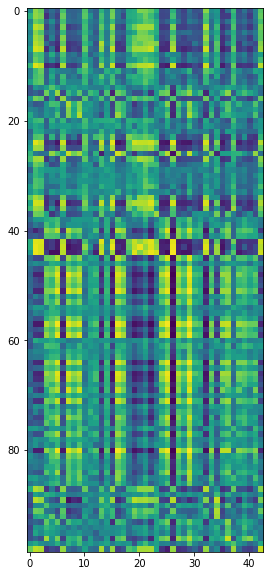

In [43]:
# Sort theo user_group + draw sigmoid/softmax layer
plt.rcParams["figure.figsize"] = (20,10)
k =100
a = group_scores
print( np.max(a), np.mean(a), np.min(a) )
ind = np.argmax(group_scores, axis=1)
plt.imshow( a[np.argsort(ind)][0:k] )

In [ ]:
# np.argsort(a[1])

In [ ]:
# [np.isin(np.argsort(a[1]), np.array([0,1,2]) )]

In [ ]:
# Vẽ theo user_group
# user_groups = [ 32 ]
# a = group_scores
# ind = np.argmax(group_scores, axis=1)
# plt.imshow( a[ np.isin( ind, user_groups)] )

In [ ]:
# Vẽ y_true của các user chung group
# y_true = model.decoder(model._preprocess( [interac_df[itemCol], interac_df["y"]], padding_size = mask_size )).numpy()
# y_true_ugrs = y_true[ np.isin( ind, user_groups)]

# for i in range(y_true_ugrs.shape[0]):
#     y_true_i = y_true_ugrs[i].reshape((50,100))
#     print( np.max(y_true_i), np.min(y_true_i), np.mean(y_true_i)  )
#     plt.imshow( y_true_i)
#     plt.show()


In [ ]:
# plt.imshow(y_true[0].reshape(50, 100) )

In [ ]:
# y_true[0][y_true[0]!=0]

In [ ]:
# y_true = model.decoder(model._preprocess( [interac_df[itemCol], interac_df["y"]], padding_size = mask_size )).numpy()[0:15]
# for i in range(y_true.shape[0]):
#     y_true_i = y_true[i].reshape((50,100))
#     print( np.max(y_true_i), np.min(y_true_i), np.mean(y_true_i)  )
#     plt.imshow( y_true_i)
#     plt.show()

In [ ]:
# for i in range(group_scores.shape[0]):
#     plt.imshow( group_scores[i].numpy().reshape((5,10)) )
#     plt.show()

In [ ]:
# plt.imshow(y_true)

# Item feature model

In [104]:
%%time
# Vectorize (encode + padding) item list
text_vocab_size = 5000

text_vectorizer = layers.TextVectorization( max_tokens= text_vocab_size, split='whitespace', output_sequence_length= wu_size, name = 'text_vect')
text_vectorizer.adapt( interac_df["item_ft_strs"].values.flatten()[0] ) 

CPU times: user 159 ms, sys: 2.25 ms, total: 161 ms
Wall time: 191 ms


In [114]:
text_vectorizer(interac_df["item_ft_strs"].values[0])

<tf.Tensor: shape=(92, 200), dtype=int64, numpy=
array([[ 34,  10,   2, ...,   0,   0,   0],
       [ 34,  10,   2, ...,   0,   0,   0],
       [ 27,  10,   2, ...,   0,   0,   0],
       ...,
       [152, 170,   2, ...,   0,   0,   0],
       [205,   2, 192, ...,   0,   0,   0],
       [153,  20,   2, ...,   0,   0,   0]])>

In [111]:
text_vectorizer(interac_df["item_ft_strs"])

ValueError: ignored

In [110]:
interac_df.head()

,movieId,y,item_ft_strs,item_ft_nums
userId,,,,
1,"[5952, 7153, 1198, 5540, 4467, 541, 296, 5026,...","[1.0, 1.0, 0.8, 0.6000000000000001, 0.60000000...","[Lord of the Rings: The Two Towers, The Advent...","[[2002], [2003], [1981], [1981], [1988], [1982..."
2,"[1210, 541, 1748, 3959, 70, 2948, 266, 1356, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",[Star Wars: Episode VI - Return of the Jedi Ac...,"[[1983], [1982], [1998], [1960], [1996], [1963..."
3,"[2118, 2710, 1084, 2076, 1060, 1375, 175, 1259...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[Dead Zone, The Thriller, Blair Witch Project,...","[[1983], [1999], [1967], [1986], [1996], [1984..."
4,"[454, 733, 596, 370, 10, 480, 586, 589, 6, 380...","[1.0, 1.0, 0.6000000000000001, 0.6000000000000...","[Firm, The Drama Thriller, Rock, The Action Ad...","[[1993], [1996], [1940], [1994], [1995], [1993..."
5,"[1136, 454, 736, 457, 62, 531, 368, 780, 594, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",[Monty Python and the Holy Grail Adventure Com...,"[[1975], [1993], [1996], [1993], [1995], [1993..."


In [107]:
# v1. dựng theo kịch bản có full string item feature và num item feature
def _wu_mask_ft_split(self, batch_inputs, mask_ratio = 0.25):
    "Chia ratings và items thành mask, warm up"
    input_items, input_ratings, input_item_strs, input_item_nums = batch_inputs[itemCol], batch_inputs["y"], batch_inputs["item_ft_strs"], batch_inputs["item_ft_nums"]

    def list_split(input, mask_ratio = 0.25, seed= 42):
        return train_test_split(input[0:(wu_size+mask_size)], test_size= mask_ratio, random_state=seed)

    def wu_mask_split(series):
        wu = series.apply(lambda x: x[0])
        mask = series.apply(lambda x: x[1])
        return wu, mask


    seed = random.randint(1, 100)
    items = input_items.apply(lambda x: list_split(x, mask_ratio, seed))
    ratings = input_ratings.apply(lambda x: list_split(x, mask_ratio, seed))
    item_str_fts = input_item_strs.apply(lambda x: list_split(x, mask_ratio, seed))
    item_num_fts = input_item_nums.apply(lambda x: list_split(x, mask_ratio, seed))

    wu_item_list, mask_item_list = wu_mask_split( items )
    wu_rating_list, mask_rating_list = wu_mask_split( ratings )
    wu_item_strft, mask_item_strft = wu_mask_split(item_str_fts)
    wu_item_numft, mask_item_numft = wu_mask_split(item_num_fts)


    return (wu_item_list, wu_rating_list), (mask_item_list, mask_rating_list), (wu_item_strft, mask_item_strft), (wu_item_numft, mask_item_numft)

Efficient_Rec._wu_mask_ft_split = _wu_mask_ft_split

In [ ]:
def _preprocess(self, inputs, padding_size = 100):
    """
    Padding về wu_size và mask_size, convert list of items => string of items
    batch_inputs: df: itemStr, y"""

    def padding_list(list_item, wu_size, value=0, is_padding=True):
        series_item1 = list_item[0:wu_size]
        if is_padding:
            series_item1 = series_item1+[value]*(wu_size-len(series_item1))
        return series_item1

    items_list, ratings_list = inputs

    items   = items_list.apply(lambda x: ' '.join(list([str(i) for i in x])))
    ratings =   np.stack( ratings_list.apply(lambda x: padding_list( x, padding_size  ) ) )

    return items, ratings

Efficient_Rec._preprocess = _preprocess

In [ ]:
# Thực hiện training
# TODO: sửa lại pd shift thành np.roll
def _constrastive_train_step(self, inputs):
    warm_up, mask = self._wu_mask_split(inputs.sample(frac=1), mask_ratio = 0.5)
    wu_items, wu_ratings = self._preprocess(warm_up, wu_size)
    mask_item, mask_ratings = self._preprocess(mask, wu_size)

    negative_items = wu_items.shift(1, axis=0, fill_value=['0 ']) #np.roll( wu_items, shift= 1, axis=0)
    negative_ratings =  np.roll( wu_ratings, shift= 1, axis=0)

    with tf.GradientTape() as tape:
        # Interaction embedding
        wu_vec = self.encoder([wu_items, wu_ratings])
        mask_vec = self.encoder([mask_item, mask_ratings])
        negative_vec = self.encoder([negative_items, negative_ratings])


        average_loss = self.loss(wu_vec, mask_vec, negative_vec)

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

Efficient_Rec._constrastive_train_step = _constrastive_train_step

# Compare

In [ ]:
pip install recommenders

In [44]:
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items, merge_ranking_true_pred)

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import NMF

In [51]:
def precision_recall_at_k(
    rating_true,
    rating_pred,
    col_user="userId",
    col_item="movieId",
    col_rating="rating",
    col_prediction="prediction",
    relevancy_method="top_k",
    k=50,
    threshold=2.6,
):
    df_hit, df_hit_count, n_users = merge_ranking_true_pred(
        rating_true=rating_true,
        rating_pred=rating_pred,
        col_user=col_user,
        col_item=col_item,
        col_rating=col_rating,
        col_prediction=col_prediction,
        relevancy_method=relevancy_method,
        k=k,
        threshold=threshold,
    )

    if df_hit.shape[0] == 0:
        print("precision: ", 0.0, "; recall: ", 0.0)
        return 0.0, 0.0


    precision = (df_hit_count["hit"] / k).sum() / n_users
    recall = (df_hit_count["hit"] / df_hit_count["actual"]).sum() / n_users
    print("precision: ", precision, "; recall: ", recall)
    return precision, recall

In [9]:
ratings_df = ratings.sample(frac=0.005)

In [10]:
ratings_df

,userId,movieId,rating,timestamp
7254605,50073,2925,4.0,949182284
1097455,7481,59315,4.5,1340102214
18137917,125493,1028,2.0,982254779
13113910,90595,30,3.0,837284844
11809741,81510,3908,1.0,1156784384
...,...,...,...,...
581899,3907,4306,3.5,1085453385
1966717,13338,288,1.0,1344152068
18370502,127138,86833,3.0,1370515300
11446260,79044,420,2.0,841524394


In [11]:
user_enc = LabelEncoder()
item_enc = LabelEncoder()

ratings_df["user_id"] = user_enc.fit_transform( ratings_df['userId'] )
ratings_df["item_id"] = user_enc.fit_transform( ratings_df['movieId'] )

In [12]:
n_users = len(ratings_df['user_id'].unique())
n_items = len(ratings_df['item_id'].unique())
R_shape = (n_users, n_items)
print ( str(n_users) + ' users' )
print ( str(n_items) + ' items' )

52380 users
8437 items


In [13]:
from scipy import sparse

def ConvertToDense(X, y, shape):  # from R=(X,y), in sparse format 
    row  = X[:,0]
    col  = X[:,1]
    data = y
    matrix_sparse = sparse.csr_matrix((data,(row,col)), shape=(shape[0]+1,shape[1]+1))  # sparse matrix in compressed format (CSR)
    R = matrix_sparse.todense()   # convert sparse matrix to dense matrix, same as: matrix_sparse.A
    R = R[1:,1:]                  # removing the "Python starts at 0" offset
    R = np.asarray(R)             # convert matrix object to ndarray object
    return R
  
n_users = len(ratings_df['user_id'].unique())
n_items = len(ratings_df['item_id'].unique())
R_shape = (n_users, n_items)
X = ratings_df[['user_id', 'item_id']].values
y = ratings_df['rating'].values

R = ConvertToDense(X, y, R_shape)
print(R)
print(R.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(52380, 8437)


In [ ]:
%%time
parametersNMF_opt = {
                    'n_components' : 20,     # number of latent factors
                    'init' : 'random', 
                    'random_state' : 0, 
                    'alpha' : 0.01,          # regularization term
                    'l1_ratio' : 0,          # set regularization = L2 
                    'max_iter' : 15
                }
estimator = NMF(**parametersNMF_opt)
                
# Training (matrix factorization)
estimator.fit(R)  
Theta = estimator.transform(R)            # user features
M = estimator.components_.T               # item features

# Making the predictions
R_pred = M.dot(Theta.T).T
                    
# Clipping values                                                    
R_pred[R_pred > 5] = 5.           # clips ratings above 5             
R_pred[R_pred < 1] = 1.           # clips ratings below 1

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 15 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [36]:
all_predictions = test_ratings[["userId", "movieId"]]

In [39]:
all_predictions["prediction"] = test_ratings["rating"].apply(lambda x: x*random.random())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
all_predictions

,userId,movieId,prediction
18233746,126096,1968,2.346875
14158115,97775,1526,0.981974
18911180,130876,597,0.715632
2950314,20054,1918,1.576155
5229491,35834,101612,0.810445
...,...,...,...
17771387,122865,1387,2.924674
4653227,31913,1748,0.103580
58284,417,2145,0.043400
14442737,99773,6711,4.357578


In [53]:
precision_recall_at_k(
    test_ratings, all_predictions,     
    col_user="userId",
    col_item="movieId",
    col_rating="rating",
    col_prediction="prediction", 
    k=50)

precision:  0.1514748750914935 ; recall:  0.9959907849492419


(0.1514748750914935, 0.9959907849492419)

In [63]:
mf = NMF()

In [ ]:
mf.fit()